In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import pandas as pd
import gc

# Function to extract ZIP files
def extract_zip(zip_file_path, extract_folder):
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

# Extract the training and test data
extract_zip('/content/drive/MyDrive/Copy of GUIDE_Train.csv.zip', '/content/extracted_folder')
extract_zip('/content/drive/MyDrive/Copy of GUIDE_Test.csv.zip', '/content/extracted_folder')

# Define the features to keep and the target column
target_column = 'IncidentGrade'
columns_to_keep = [
    'AlertTitle', 'Timestamp' ,'Category', 'MitreTechniques', 'ActionGrouped', 'ActionGranular',
    'EntityType', 'EvidenceRole', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
    'LastVerdict', 'CountryCode', 'State', 'City', 'ThreatFamily', 'DetectorId',
    'DeviceId', 'FileName', 'FolderPath', 'AntispamDirection', 'IpAddress', 'Sha256', 'Url'
]

# Function to downcast numerical columns to save memory
def downcast_dataframe(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

# Function to remove columns with more than 80% null values
def drop_high_null_columns(df, threshold=0.8):
    null_percentage = df.isnull().mean()
    cols_to_drop = null_percentage[null_percentage > threshold].index
    df = df.drop(columns=cols_to_drop)
    return df

# Function to process CSV in chunks
def process_csv_in_chunks(csv_file_path, features, target_column, chunk_size=100000):
    chunk_list = []

    for chunk in pd.read_csv(csv_file_path, chunksize=chunk_size, low_memory=False):
        # Select relevant columns
        chunk = chunk[[target_column] + features]

        # Downcast the data types to reduce memory usage
        chunk = downcast_dataframe(chunk)

        # Drop columns with more than 80% null values
        chunk = drop_high_null_columns(chunk, threshold=0.8)

        # Drop duplicates
        chunk = chunk.drop_duplicates()

        # Store processed chunk
        chunk_list.append(chunk)

        # Clear memory
        del chunk
        gc.collect()

    # Concatenate all processed chunks into a single DataFrame
    return pd.concat(chunk_list, ignore_index=True)

# Process Train DataFrame
train_csv_path = '/content/extracted_folder/GUIDE_Train.csv'
train_df = process_csv_in_chunks(train_csv_path, columns_to_keep, target_column)

# Process Test DataFrame
test_csv_path = '/content/extracted_folder/GUIDE_Test.csv'
test_df = process_csv_in_chunks(test_csv_path, columns_to_keep, target_column)

# Define paths for saving the .pkl files
train_pkl_path = '/content/extracted_folder/train_df.pkl'
test_pkl_path = '/content/extracted_folder/test_df.pkl'

# Save DataFrames as .pkl files
train_df.to_pickle(train_pkl_path)
test_df.to_pickle(test_pkl_path)

# Display first 5 rows of each DataFrame
print("Train DataFrame:")
print(train_df.head(5))
print("\nTest DataFrame:")
print(test_df.head(5))


Train DataFrame:
    IncidentGrade  AlertTitle                 Timestamp           Category  \
0    TruePositive           6  2024-06-04T06:05:15.000Z      InitialAccess   
1   FalsePositive          43  2024-06-14T03:01:25.000Z       Exfiltration   
2   FalsePositive         298  2024-06-13T04:52:55.000Z      InitialAccess   
3  BenignPositive           2  2024-06-10T16:39:36.000Z  CommandAndControl   
4    TruePositive          74  2024-06-15T01:08:07.000Z          Execution   

  MitreTechniques EntityType EvidenceRole  OSFamily  OSVersion LastVerdict  \
0             NaN         Ip      Related         5         66         NaN   
1             NaN       User     Impacted         5         66         NaN   
2           T1189        Url      Related         5         66  Suspicious   
3             NaN        Url      Related         5         66  Suspicious   
4             NaN       User     Impacted         5         66         NaN   

   CountryCode  State   City  DetectorId  Dev

In [ ]:
import pandas as pd
train_df=pd.read_pickle('/content/extracted_folder/train_df.pkl')
test_df=pd.read_pickle('/content/extracted_folder/test_df.pkl')

In [ ]:
print(train_df.shape)
print(test_df.shape)

(9043211, 20)
(3836773, 20)


In [ ]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9043211 entries, 0 to 9043210
Data columns (total 20 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   IncidentGrade    object
 1   AlertTitle       int32 
 2   Timestamp        object
 3   Category         object
 4   MitreTechniques  object
 5   EntityType       object
 6   EvidenceRole     object
 7   OSFamily         int8  
 8   OSVersion        int8  
 9   LastVerdict      object
 10  CountryCode      int16 
 11  State            int16 
 12  City             int16 
 13  DetectorId       int16 
 14  DeviceId         int32 
 15  FileName         int32 
 16  FolderPath       int32 
 17  IpAddress        int32 
 18  Sha256           int32 
 19  Url              int32 
dtypes: int16(4), int32(7), int8(2), object(7)
memory usage: 810.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3836773 entries, 0 to 3836772
Data columns (total 20 columns):
 #   Column           Dtype 
---  ------           ----- 
 0

In [ ]:
train_df.columns

Index(['IncidentGrade', 'AlertTitle', 'Timestamp', 'Category',
       'MitreTechniques', 'EntityType', 'EvidenceRole', 'OSFamily',
       'OSVersion', 'LastVerdict', 'CountryCode', 'State', 'City',
       'DetectorId', 'DeviceId', 'FileName', 'FolderPath', 'IpAddress',
       'Sha256', 'Url'],
      dtype='object')

In [ ]:
print(train_df.isnull().sum()/len(train_df)*100)
print(test_df.isnull().sum()/len(test_df)*100)


IncidentGrade       0.559093
AlertTitle          0.000000
Timestamp           0.000000
Category            0.000000
MitreTechniques    58.559830
EntityType          0.000000
EvidenceRole        0.000000
OSFamily            0.000000
OSVersion           0.000000
LastVerdict        75.390743
CountryCode         0.000000
State               0.000000
City                0.000000
DetectorId          0.000000
DeviceId            0.000000
FileName            0.000000
FolderPath          0.000000
IpAddress           0.000000
Sha256              0.000000
Url                 0.000000
dtype: float64
IncidentGrade       0.000000
AlertTitle          0.000000
Timestamp           0.000000
Category            0.000000
MitreTechniques    57.518232
EntityType          0.000000
EvidenceRole        0.000000
OSFamily            0.000000
OSVersion           0.000000
LastVerdict        74.246821
CountryCode         0.000000
State               0.000000
City                0.000000
DetectorId          0.000000

In [ ]:
#incident grade null values treatment
train_df = train_df.dropna(subset=['IncidentGrade'])

In [ ]:
#drop IpAddress Sha256: FileName: FolderPath  DeviceId Url  High cardinality, likely not useful for modeling,does not provide significant additional information.
# List of columns to drop
import pandas as pd

# Load DataFrames (assuming they are already loaded into train_df and test_df)
# train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

# Define columns to drop based on your analysis
columns_to_drop = [
    'Sha256',     # High cardinality, likely not useful
    "FileName",
    "FolderPath",
    "Url"
      # May not add value if it doesn't provide significant variation
      # doesnt provide significant information
]

# Drop the specified columns from both DataFrames
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

# Fill null values in 'MitreTechniques' and 'LastVerdict' with 'unknown'
#train_df['MitreTechniques'] = train_df['MitreTechniques'].fillna('unknown')
#test_df['MitreTechniques'] = test_df['MitreTechniques'].fillna('unknown')

train_df['LastVerdict'] = train_df['LastVerdict'].fillna('unknown')
test_df['LastVerdict'] = test_df['LastVerdict'].fillna('unknown')

#



In [ ]:
# Fill null values in 'MitreTechniques' and 'LastVerdict' with 'unknown'
train_df['MitreTechniques'] = train_df['MitreTechniques'].fillna('unknown')
test_df['MitreTechniques'] = test_df['MitreTechniques'].fillna('unknown')

In [ ]:
print(train_df.shape)
print(test_df.shape)

(8992651, 16)
(3836773, 16)


In [ ]:
print(train_df.isnull().sum()/len(train_df)*100)
print(test_df.isnull().sum()/len(test_df)*100)


IncidentGrade      0.0
AlertTitle         0.0
Timestamp          0.0
Category           0.0
MitreTechniques    0.0
EntityType         0.0
EvidenceRole       0.0
OSFamily           0.0
OSVersion          0.0
LastVerdict        0.0
CountryCode        0.0
State              0.0
City               0.0
DetectorId         0.0
DeviceId           0.0
IpAddress          0.0
dtype: float64
IncidentGrade      0.0
AlertTitle         0.0
Timestamp          0.0
Category           0.0
MitreTechniques    0.0
EntityType         0.0
EvidenceRole       0.0
OSFamily           0.0
OSVersion          0.0
LastVerdict        0.0
CountryCode        0.0
State              0.0
City               0.0
DetectorId         0.0
DeviceId           0.0
IpAddress          0.0
dtype: float64


In [ ]:
train_df.columns

Index(['IncidentGrade', 'AlertTitle', 'Timestamp', 'Category',
       'MitreTechniques', 'EntityType', 'EvidenceRole', 'OSFamily',
       'OSVersion', 'LastVerdict', 'CountryCode', 'State', 'City',
       'DetectorId', 'DeviceId', 'IpAddress'],
      dtype='object')

In [ ]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())


3669546
1136919


In [ ]:
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(5323105, 16)
(2699854, 16)


In [ ]:
import pandas as pd

# Function to create new time-based and IP-based features
def engineer_features(df):
    # Convert 'Timestamp' to datetime and extract time-based features
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Hour'] = df['Timestamp'].dt.hour
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
    df['Month'] = df['Timestamp'].dt.month
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

    # Optional: Drop the original Timestamp column after feature extraction
    df = df.drop(columns=['Timestamp'])

    return df
# Apply feature engineering to train_df and test_df
train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

# Check the result by printing the first few rows
print(train_df.head(5))
print(test_df.head(5))

    IncidentGrade  AlertTitle           Category MitreTechniques EntityType  \
0    TruePositive           6      InitialAccess         unknown         Ip   
1   FalsePositive          43       Exfiltration         unknown       User   
2   FalsePositive         298      InitialAccess           T1189        Url   
3  BenignPositive           2  CommandAndControl         unknown        Url   
4    TruePositive          74          Execution         unknown       User   

  EvidenceRole  OSFamily  OSVersion LastVerdict  CountryCode  State   City  \
0      Related         5         66     unknown           31      6      3   
1     Impacted         5         66     unknown          242   1445  10630   
2      Related         5         66  Suspicious          242   1445  10630   
3      Related         5         66  Suspicious          242   1445  10630   
4     Impacted         5         66     unknown          242   1445  10630   

   DetectorId  DeviceId  IpAddress  Hour  DayOfWeek  Mon

In [ ]:
def print_value_counts(df):
    for col in df.columns:
        print(f"Value counts for column '{col}':")
        print(df[col].value_counts())
        print("\n")

# Call the function with your DataFrames
print_value_counts(train_df)
print_value_counts(test_df)


Value counts for column 'IncidentGrade':
IncidentGrade
TruePositive      2108932
BenignPositive    2105324
FalsePositive     1108849
Name: count, dtype: int64


Value counts for column 'AlertTitle':
AlertTitle
0         941518
2         375290
1         355216
4         310896
3         301360
           ...  
105927         1
110272         1
111202         1
109534         1
112743         1
Name: count, Length: 79952, dtype: int64


Value counts for column 'Category':
Category
InitialAccess          2609492
SuspiciousActivity      714317
Impact                  564263
CommandAndControl       487334
Exfiltration            395941
CredentialAccess        163202
Execution               155133
Malware                  74984
Discovery                46174
Persistence              28578
DefenseEvasion           26062
LateralMovement          24181
UnwantedSoftware         12500
Ransomware                8202
Collection                7584
Exploit                   2594
PrivilegeEscalation

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5323105 entries, 0 to 9043201
Data columns (total 19 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   IncidentGrade    object
 1   AlertTitle       int32 
 2   Category         object
 3   MitreTechniques  object
 4   EntityType       object
 5   EvidenceRole     object
 6   OSFamily         int8  
 7   OSVersion        int8  
 8   LastVerdict      object
 9   CountryCode      int16 
 10  State            int16 
 11  City             int16 
 12  DetectorId       int16 
 13  DeviceId         int32 
 14  IpAddress        int32 
 15  Hour             int32 
 16  DayOfWeek        int32 
 17  Month            int32 
 18  IsWeekend        int64 
dtypes: int16(4), int32(6), int64(1), int8(2), object(6)
memory usage: 497.5+ MB


In [ ]:
train_df.head(10)

,IncidentGrade,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,OSFamily,OSVersion,LastVerdict,CountryCode,State,City,DetectorId,DeviceId,IpAddress,Hour,DayOfWeek,Month,IsWeekend
0,TruePositive,6,InitialAccess,unknown,Ip,Related,5,66,unknown,31,6,3,7,98799,27,6,1,6,0
1,FalsePositive,43,Exfiltration,unknown,User,Impacted,5,66,unknown,242,1445,10630,58,98799,360606,3,4,6,0
2,FalsePositive,298,InitialAccess,T1189,Url,Related,5,66,Suspicious,242,1445,10630,423,98799,360606,4,3,6,0
3,BenignPositive,2,CommandAndControl,unknown,Url,Related,5,66,Suspicious,242,1445,10630,2,98799,360606,16,0,6,0
4,TruePositive,74,Execution,unknown,User,Impacted,5,66,unknown,242,1445,10630,9,98799,360606,1,5,6,1
5,FalsePositive,0,InitialAccess,T1078;T1078.004,Ip,Related,5,66,unknown,8,6,3,0,98799,30410,13,0,6,0
6,BenignPositive,2,CommandAndControl,unknown,Url,Related,5,66,Suspicious,242,1445,10630,2,98799,360606,23,4,6,0
7,BenignPositive,3919,Exfiltration,unknown,MailMessage,Impacted,5,66,unknown,242,1445,10630,313,98799,360606,13,3,6,0
8,BenignPositive,4,SuspiciousActivity,unknown,Process,Related,5,66,Suspicious,242,1445,10630,3,98799,360606,10,6,6,1
9,TruePositive,3,InitialAccess,unknown,User,Impacted,5,66,unknown,242,1445,10630,4,98799,360606,2,5,6,1


In [ ]:
train_df.isnull().sum()
test_df.isnull().sum()

,0
IncidentGrade,0
AlertTitle,0
Category,0
MitreTechniques,0
EntityType,0
EvidenceRole,0
OSFamily,0
OSVersion,0
LastVerdict,0
CountryCode,0


In [ ]:
print(train_df.shape)
print(test_df.shape)


(5323105, 19)
(2699854, 19)


In [ ]:
#Encoding
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder



# Define the order of IncidentGrade
grade_order = ['BenignPositive', 'FalsePositive', 'TruePositive']

# Initialize the Ordinal Encoder
ordinal_encoder = OrdinalEncoder(categories=[grade_order])

# Fit the encoder on the training data and transform it
train_df['IncidentGrade_encoded'] = ordinal_encoder.fit_transform(train_df[['IncidentGrade']])

# Apply the same encoding to the test data
test_df['IncidentGrade_encoded'] = ordinal_encoder.transform(test_df[['IncidentGrade']])

# Show the results
print("Encoded Training DataFrame:")
print(train_df)

print("\nEncoded Testing DataFrame:")
print(test_df)


Encoded Training DataFrame:
          IncidentGrade  AlertTitle           Category  MitreTechniques  \
0          TruePositive           6      InitialAccess          unknown   
1         FalsePositive          43       Exfiltration          unknown   
2         FalsePositive         298      InitialAccess            T1189   
3        BenignPositive           2  CommandAndControl          unknown   
4          TruePositive          74          Execution          unknown   
...                 ...         ...                ...              ...   
9043190    TruePositive           3      InitialAccess          unknown   
9043194  BenignPositive          75      InitialAccess          unknown   
9043197  BenignPositive           1      InitialAccess        T1566.002   
9043198   FalsePositive          15      InitialAccess          unknown   
9043201    TruePositive           0      InitialAccess  T1078;T1078.004   

          EntityType EvidenceRole  OSFamily  OSVersion LastVerdict  \
0

In [ ]:
train_df.drop(["IncidentGrade"],axis=1,inplace=True)
test_df.drop(["IncidentGrade"],axis=1,inplace=True)

In [ ]:
train_df_eda=train_df.copy()
test_df_eda=test_df.copy()

In [ ]:
train_df_eda.columns

Index(['AlertTitle', 'Category', 'MitreTechniques', 'EntityType',
       'EvidenceRole', 'OSFamily', 'OSVersion', 'LastVerdict', 'CountryCode',
       'State', 'City', 'DetectorId', 'DeviceId', 'IpAddress', 'Hour',
       'DayOfWeek', 'Month', 'IsWeekend', 'IncidentGrade_encoded'],
      dtype='object')

In [ ]:
train_df.columns

Index(['AlertTitle', 'Category', 'MitreTechniques', 'EntityType',
       'EvidenceRole', 'OSFamily', 'OSVersion', 'LastVerdict', 'CountryCode',
       'State', 'City', 'DetectorId', 'DeviceId', 'IpAddress', 'Hour',
       'DayOfWeek', 'Month', 'IsWeekend', 'IncidentGrade_encoded'],
      dtype='object')

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths where you want to save the pickle files
train_df_path = '/content/drive/MyDrive/train_df_eda.pkl'
test_df_path = '/content/drive/MyDrive/test_df_eda.pkl'

# Assuming train_df and test_df are already loaded DataFrames
# Save the DataFrames to pickle files
train_df_eda.to_pickle(train_df_path)
test_df_eda.to_pickle(test_df_path)

print(f"train_df saved to {train_df_path}")
print(f"test_df saved to {test_df_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train_df saved to /content/drive/MyDrive/train_df_eda.pkl
test_df saved to /content/drive/MyDrive/test_df_eda.pkl


In [ ]:
import pandas as pd
train_df=pd.read_pickle('/content/drive/MyDrive/train_df_eda.pkl')
test_df=pd.read_pickle('/content/drive/MyDrive/test_df_eda.pkl')



In [ ]:
train_df.columns

Index(['AlertTitle', 'Category', 'MitreTechniques', 'EntityType',
       'EvidenceRole', 'OSFamily', 'OSVersion', 'LastVerdict', 'CountryCode',
       'State', 'City', 'DetectorId', 'DeviceId', 'IpAddress', 'Hour',
       'DayOfWeek', 'Month', 'IsWeekend', 'IncidentGrade_encoded'],
      dtype='object')

In [ ]:
train_df.shape

(5323105, 19)

In [ ]:
train_df_eda.columns

Index(['IncidentGrade', 'AlertTitle', 'Category', 'MitreTechniques',
       'EntityType', 'EvidenceRole', 'OSFamily', 'OSVersion', 'LastVerdict',
       'CountryCode', 'State', 'City', 'DetectorId', 'DeviceId', 'IpAddress',
       'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IncidentGrade_encoded'],
      dtype='object')

In [ ]:
train_df.head(5)

,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,OSFamily,OSVersion,LastVerdict,CountryCode,State,City,DetectorId,DeviceId,IpAddress,Hour,DayOfWeek,Month,IsWeekend,IncidentGrade_encoded
0,6,InitialAccess,unknown,Ip,Related,5,66,unknown,31,6,3,7,98799,27,6,1,6,0,2.0
1,43,Exfiltration,unknown,User,Impacted,5,66,unknown,242,1445,10630,58,98799,360606,3,4,6,0,1.0
2,298,InitialAccess,T1189,Url,Related,5,66,Suspicious,242,1445,10630,423,98799,360606,4,3,6,0,1.0
3,2,CommandAndControl,unknown,Url,Related,5,66,Suspicious,242,1445,10630,2,98799,360606,16,0,6,0,0.0
4,74,Execution,unknown,User,Impacted,5,66,unknown,242,1445,10630,9,98799,360606,1,5,6,1,2.0


In [ ]:
import pandas as pd



# Ensure columns are of type str
for column in ['EvidenceRole', 'LastVerdict', 'OSFamily']:
    train_df[column] = train_df[column].astype(str).str.lower()
    test_df[column] = test_df[column].astype(str).str.lower()

# Calculate frequency encoding from the training set
freq_encodings = {}
for column in ['EvidenceRole', 'LastVerdict', 'OSFamily']:
    freq_encodings[column] = train_df[column].value_counts(normalize=True)
    print(f"Frequency encoding for {column}:\n", freq_encodings[column])

# Apply frequency encoding to both train and test sets
for column in ['EvidenceRole', 'LastVerdict', 'OSFamily']:
    # Train set encoding
    train_df[f'{column}_encoded'] = train_df[column].map(freq_encodings[column])

    # Test set encoding
    test_df[f'{column}_encoded'] = test_df[column].map(freq_encodings[column])

# Check for NaN values after mapping and handle missing values
for column in ['EvidenceRole', 'LastVerdict', 'OSFamily']:
    # Train set NaN check
    nan_count_train = train_df[f'{column}_encoded'].isna().sum()
    print(f"Number of NaN values in {column}_encoded (train):", nan_count_train)
    train_df[f'{column}_encoded'].fillna(0, inplace=True)

    # Test set NaN check
    nan_count_test = test_df[f'{column}_encoded'].isna().sum()
    print(f"Number of NaN values in {column}_encoded (test):", nan_count_test)
    test_df[f'{column}_encoded'].fillna(0, inplace=True)

# Preview the results
print("\nPreview of the training DataFrame:\n", train_df[['EvidenceRole', 'EvidenceRole_encoded',
                                                       'LastVerdict', 'LastVerdict_encoded',
                                                       'OSFamily', 'OSFamily_encoded']].head(10))

print("\nPreview of the test DataFrame:\n", test_df[['EvidenceRole', 'EvidenceRole_encoded',
                                                  'LastVerdict', 'LastVerdict_encoded',
                                                  'OSFamily', 'OSFamily_encoded']].head(10))


Frequency encoding for EvidenceRole:
 EvidenceRole
related     0.622588
impacted    0.377412
Name: proportion, dtype: float64
Frequency encoding for LastVerdict:
 LastVerdict
unknown                                               7.399893e-01
suspicious                                            1.712222e-01
nothreatsfound                                        4.524803e-02
malicious                                             4.352741e-02
domainpii_50d8b4a941c26b89482c94ab324b5a274f9ced66    1.239878e-05
domainpii_9207384283ce115db5a590dd9ca5de21e5e99df2    5.635808e-07
Name: proportion, dtype: float64
Frequency encoding for OSFamily:
 OSFamily
5    9.705191e-01
0    2.881589e-02
1    4.131048e-04
2    2.504178e-04
3    1.315022e-06
4    1.878603e-07
Name: proportion, dtype: float64
Number of NaN values in EvidenceRole_encoded (train): 0
Number of NaN values in EvidenceRole_encoded (test): 0
Number of NaN values in LastVerdict_encoded (train): 0
Number of NaN values in LastVerdict_enco

In [ ]:
train_df.head(10)

,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,OSFamily,OSVersion,LastVerdict,CountryCode,State,...,DeviceId,IpAddress,Hour,DayOfWeek,Month,IsWeekend,IncidentGrade_encoded,EvidenceRole_encoded,LastVerdict_encoded,OSFamily_encoded
0,6,InitialAccess,unknown,Ip,related,5,66,unknown,31,6,...,98799,27,6,1,6,0,2.0,0.622588,0.739989,0.970519
1,43,Exfiltration,unknown,User,impacted,5,66,unknown,242,1445,...,98799,360606,3,4,6,0,1.0,0.377412,0.739989,0.970519
2,298,InitialAccess,T1189,Url,related,5,66,suspicious,242,1445,...,98799,360606,4,3,6,0,1.0,0.622588,0.171222,0.970519
3,2,CommandAndControl,unknown,Url,related,5,66,suspicious,242,1445,...,98799,360606,16,0,6,0,0.0,0.622588,0.171222,0.970519
4,74,Execution,unknown,User,impacted,5,66,unknown,242,1445,...,98799,360606,1,5,6,1,2.0,0.377412,0.739989,0.970519
5,0,InitialAccess,T1078;T1078.004,Ip,related,5,66,unknown,8,6,...,98799,30410,13,0,6,0,1.0,0.622588,0.739989,0.970519
6,2,CommandAndControl,unknown,Url,related,5,66,suspicious,242,1445,...,98799,360606,23,4,6,0,0.0,0.622588,0.171222,0.970519
7,3919,Exfiltration,unknown,MailMessage,impacted,5,66,unknown,242,1445,...,98799,360606,13,3,6,0,0.0,0.377412,0.739989,0.970519
8,4,SuspiciousActivity,unknown,Process,related,5,66,suspicious,242,1445,...,98799,360606,10,6,6,1,0.0,0.622588,0.171222,0.970519
9,3,InitialAccess,unknown,User,impacted,5,66,unknown,242,1445,...,98799,360606,2,5,6,1,2.0,0.377412,0.739989,0.970519


In [ ]:
import pandas as pd

# Load your data (adjust paths as needed)
# train_df = pd.read_csv('train_data.csv')
# test_df = pd.read_csv('test_data.csv')

# Step 1: Set the frequency threshold
threshold = 100  # Categories appearing less than 100 times will be grouped into "Other"

# Step 2: Calculate the frequency of each category in the training set
frequency_map_train = train_df['MitreTechniques'].value_counts()

# Step 3: Identify categories in the training set that are below the threshold and group them as 'Other'
rare_categories_train = frequency_map_train[frequency_map_train < threshold].index
train_df['MitreTechniques_grouped'] = train_df['MitreTechniques'].replace(rare_categories_train, 'Other')

# Step 4: Apply the same grouping to the test set using the rare categories identified from the training set
test_df['MitreTechniques_grouped'] = test_df['MitreTechniques'].replace(rare_categories_train, 'Other')

# Step 5: Perform frequency encoding on the grouped column in the training set
frequency_map_grouped_train = train_df['MitreTechniques_grouped'].value_counts()
train_df['MitreTechniques_encoded'] = train_df['MitreTechniques_grouped'].map(frequency_map_grouped_train)

# Handle unseen categories in test set
# Map frequencies from the training set and set unseen categories to 0 or another placeholder value
test_df['MitreTechniques_encoded'] = test_df['MitreTechniques_grouped'].map(frequency_map_grouped_train).fillna(0)

# Step 6: Handle missing values (optional) - Fill missing encoded values with 0 for both train and test
train_df['MitreTechniques_encoded'] = train_df['MitreTechniques_encoded'].fillna(0)
test_df['MitreTechniques_encoded'] = test_df['MitreTechniques_encoded'].fillna(0)

# Convert encoded columns to integer type
train_df['MitreTechniques_encoded'] = train_df['MitreTechniques_encoded'].astype(int)
test_df['MitreTechniques_encoded'] = test_df['MitreTechniques_encoded'].astype(int)

# Optionally, drop the grouped column after encoding
train_df.drop(columns=['MitreTechniques_grouped'], inplace=True)
test_df.drop(columns=['MitreTechniques_grouped'], inplace=True)

# Your data is now preprocessed and ready for model training


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5323105 entries, 0 to 9043201
Data columns (total 23 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   AlertTitle               int32  
 1   Category                 object 
 2   MitreTechniques          object 
 3   EntityType               object 
 4   EvidenceRole             object 
 5   OSFamily                 object 
 6   OSVersion                int8   
 7   LastVerdict              object 
 8   CountryCode              int16  
 9   State                    int16  
 10  City                     int16  
 11  DetectorId               int16  
 12  DeviceId                 int32  
 13  IpAddress                int32  
 14  Hour                     int32  
 15  DayOfWeek                int32  
 16  Month                    int32  
 17  IsWeekend                int64  
 18  IncidentGrade_encoded    float64
 19  EvidenceRole_encoded     float64
 20  LastVerdict_encoded      float64
 21  OSFamily_enco

In [ ]:
import pandas as pd



# List of columns to check
columns_to_check = ['Category', 'EntityType', 'CountryCode', 'State', 'City',
                     'AlertTitle', 'DetectorId', 'DeviceId', 'OSVersion', 'IpAddress']

# Check for unseen categories
for column in columns_to_check:
    train_categories = set(train_df[column].unique())
    test_categories = set(test_df[column].unique())

    unseen_categories = test_categories - train_categories
    if unseen_categories:
        print(f"Unseen categories in test set for '{column}': {unseen_categories}")
    else:
        print(f"No unseen categories in test set for '{column}'")


No unseen categories in test set for 'Category'
No unseen categories in test set for 'EntityType'
Unseen categories in test set for 'CountryCode': {224, 232, 234, 203, 235, 206, 221}
Unseen categories in test set for 'State': {1030, 1050, 1055, 1081, 1084, 1100, 1153, 1179, 1194, 1205, 1206, 1214, 1215, 1217, 1218, 1225, 1236, 1245, 1249, 1256, 1259, 1266, 1270, 1272, 1273, 1274, 1283, 1286, 1297, 1298, 1304, 1313, 1319, 1320, 1330, 1333, 1334, 1336, 1337, 1338, 1339, 829, 1344, 1346, 1348, 1353, 1354, 1355, 1360, 1362, 1376, 1378, 1379, 1381, 1385, 1389, 1390, 1398, 1399, 1404, 1405, 1406, 1408, 1409, 1417, 1419, 1421, 1422, 1429, 1430, 1433, 1437, 1438, 1442, 1444, 935, 973}
Unseen categories in test set for 'City': {8195, 8202, 8204, 8209, 8217, 8219, 8223, 8225, 8226, 8233, 8235, 8237, 8244, 8247, 8248, 8250, 8255, 8256, 8258, 8269, 8271, 8272, 8273, 8275, 8278, 8280, 8286, 8290, 8293, 8298, 8301, 8306, 8315, 8319, 8321, 8324, 8326, 8327, 8329, 8334, 8335, 8337, 8339, 8340, 8350, 8

In [ ]:
import pandas as pd

# Function to apply bucketing and frequency encoding
def bucket_and_encode(train_df, test_df, column_name, top_n):
    # Frequency counts from training data
    frequency_counts = train_df[column_name].value_counts()

    # Determine top categories from training data
    top_categories = frequency_counts.head(top_n).index.tolist()
    top_categories.append('Other')

    # Apply bucketing to the training data
    train_df[f'{column_name}_Bucketed'] = train_df[column_name].apply(lambda x: x if x in top_categories else 'Other')

    # Apply bucketing to the test data (use the same top categories as training)
    test_df[f'{column_name}_Bucketed'] = test_df[column_name].apply(lambda x: x if x in top_categories else 'Other')

    # Frequency encoding on training data
    bucket_frequency_counts = train_df[f'{column_name}_Bucketed'].value_counts()
    bucket_frequency_encoding = bucket_frequency_counts.to_dict()

    # Apply frequency encoding to the training data
    train_df[f'{column_name}_Bucketed_Frequency_Encoded'] = train_df[f'{column_name}_Bucketed'].map(bucket_frequency_encoding).fillna(0)

    # Apply frequency encoding to the test data (using the encoding from the training set)
    test_df[f'{column_name}_Bucketed_Frequency_Encoded'] = test_df[f'{column_name}_Bucketed'].map(bucket_frequency_encoding).fillna(0)

    return train_df, test_df

# List of columns and top_n values for bucketing and encoding
columns_to_encode = {
    'Category': 10,
    'EntityType': 10,
    'CountryCode': 10,
    'State': 10,
    'City': 10,
    'AlertTitle': 25,
    'DetectorId': 25,
    'DeviceId': 25,
    'OSVersion': 25,
    'IpAddress': 25
}

# Apply bucketing and frequency encoding to each column
for column_name, top_n in columns_to_encode.items():
    train_df, test_df = bucket_and_encode(train_df, test_df, column_name, top_n)

# Display the results
print("Training DataFrame:")
print(train_df.head(5))

print("\nTest DataFrame:")
print(test_df.head(5))


Training DataFrame:
   AlertTitle           Category MitreTechniques EntityType EvidenceRole  \
0           6      InitialAccess         unknown         Ip      related   
1          43       Exfiltration         unknown       User     impacted   
2         298      InitialAccess           T1189        Url      related   
3           2  CommandAndControl         unknown        Url      related   
4          74          Execution         unknown       User     impacted   

  OSFamily  OSVersion LastVerdict  CountryCode  State  ...  \
0        5         66     unknown           31      6  ...   
1        5         66     unknown          242   1445  ...   
2        5         66  suspicious          242   1445  ...   
3        5         66  suspicious          242   1445  ...   
4        5         66     unknown          242   1445  ...   

   AlertTitle_Bucketed  AlertTitle_Bucketed_Frequency_Encoded  \
0                    6                                 213654   
1                Oth

In [ ]:
train_df.columns

Index(['IncidentGrade', 'AlertTitle', 'Category', 'MitreTechniques',
       'EntityType', 'EvidenceRole', 'OSFamily', 'OSVersion', 'LastVerdict',
       'CountryCode', 'State', 'City', 'DetectorId', 'DeviceId', 'IpAddress',
       'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IncidentGrade_encoded',
       'EvidenceRole_encoded', 'LastVerdict_encoded', 'OSFamily_encoded',
       'MitreTechniques_encoded', 'Category_Bucketed',
       'Category_Bucketed_Frequency_Encoded', 'EntityType_Bucketed',
       'EntityType_Bucketed_Frequency_Encoded', 'CountryCode_Bucketed',
       'CountryCode_Bucketed_Frequency_Encoded', 'State_Bucketed',
       'State_Bucketed_Frequency_Encoded', 'City_Bucketed',
       'City_Bucketed_Frequency_Encoded', 'AlertTitle_Bucketed',
       'AlertTitle_Bucketed_Frequency_Encoded', 'DetectorId_Bucketed',
       'DetectorId_Bucketed_Frequency_Encoded', 'DeviceId_Bucketed',
       'DeviceId_Bucketed_Frequency_Encoded', 'OSVersion_Bucketed',
       'OSVersion_Bucketed_Freq

In [ ]:
columns_to_drop = ['MitreTechniques','AlertTitle', 'Category', 'EntityType', 'EvidenceRole',
                   'OSFamily', 'OSVersion', 'LastVerdict', 'CountryCode',
                   'State', 'City', 'DetectorId', 'DeviceId', 'IpAddress',
                   'Category_Bucketed', 'EntityType_Bucketed',
                   'CountryCode_Bucketed', 'State_Bucketed',
                   'City_Bucketed', 'AlertTitle_Bucketed',
                   'DetectorId_Bucketed', 'DeviceId_Bucketed',
                   'OSVersion_Bucketed', 'IpAddress_Bucketed']

train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

# Check the resulting DataFrames
print("Training DataFrame after dropping columns:")
print(train_df.head(2))

print("\nTest DataFrame after dropping columns:")
print(test_df.head(2))


Training DataFrame after dropping columns:
   Hour  DayOfWeek  Month  IsWeekend  IncidentGrade_encoded  \
0     6          1      6          0                    2.0   
1     3          4      6          0                    1.0   

   EvidenceRole_encoded  LastVerdict_encoded  OSFamily_encoded  \
0              0.622588             0.739989          0.970519   
1              0.377412             0.739989          0.970519   

   MitreTechniques_encoded  Category_Bucketed_Frequency_Encoded  \
0                  3105855                              2609492   
1                  3105855                               395941   

   EntityType_Bucketed_Frequency_Encoded  \
0                                1659927   
1                                1081692   

   CountryCode_Bucketed_Frequency_Encoded  State_Bucketed_Frequency_Encoded  \
0                                  183216                             13209   
1                                 4763903                           4851679

In [ ]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

5054270
2508162


In [ ]:
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(268835, 19)
(191692, 19)


In [ ]:
train_df.columns

Index(['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IncidentGrade_encoded',
       'EvidenceRole_encoded', 'LastVerdict_encoded', 'OSFamily_encoded',
       'MitreTechniques_encoded', 'Category_Bucketed_Frequency_Encoded',
       'EntityType_Bucketed_Frequency_Encoded',
       'CountryCode_Bucketed_Frequency_Encoded',
       'State_Bucketed_Frequency_Encoded', 'City_Bucketed_Frequency_Encoded',
       'AlertTitle_Bucketed_Frequency_Encoded',
       'DetectorId_Bucketed_Frequency_Encoded',
       'DeviceId_Bucketed_Frequency_Encoded',
       'OSVersion_Bucketed_Frequency_Encoded',
       'IpAddress_Bucketed_Frequency_Encoded'],
      dtype='object')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268835 entries, 0 to 9043179
Data columns (total 19 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Hour                                    268835 non-null  int32  
 1   DayOfWeek                               268835 non-null  int32  
 2   Month                                   268835 non-null  int32  
 3   IsWeekend                               268835 non-null  int64  
 4   IncidentGrade_encoded                   268835 non-null  float64
 5   EvidenceRole_encoded                    268835 non-null  float64
 6   LastVerdict_encoded                     268835 non-null  float64
 7   OSFamily_encoded                        268835 non-null  float64
 8   MitreTechniques_encoded                 268835 non-null  int64  
 9   Category_Bucketed_Frequency_Encoded     268835 non-null  int64  
 10  EntityType_Bucketed_Frequency_Encoded   268835 n

In [ ]:
import pandas as pd

# Define the feature engineering function
def feature_engineering(df):
    # Binning Hour, DayOfWeek, and Month
    df['Hour_Binned'] = pd.cut(df['Hour'], bins=[0, 6, 12, 18, 24], labels=['Early Morning', 'Morning', 'Afternoon', 'Evening'])
    df['DayOfWeek_Binned'] = pd.cut(df['DayOfWeek'], bins=[-1, 1, 3, 5, 6], labels=['Start of Week', 'Mid Week', 'Late Week', 'Weekend'])
    df['Month_Binned'] = pd.cut(df['Month'], bins=[0, 3, 6, 9, 12], labels=['Q1', 'Q2', 'Q3', 'Q4'])

    # Create interactions
    df['Hour_DayOfWeek_Interaction'] = df['Hour'] * df['DayOfWeek']
    df['Hour_Month_Interaction'] = df['Hour'] * df['Month']

    # Normalize encoded columns
    df['CountryCode_Bucketed_Frequency_Encoded_Norm'] = (df['CountryCode_Bucketed_Frequency_Encoded'] - df['CountryCode_Bucketed_Frequency_Encoded'].min()) / (df['CountryCode_Bucketed_Frequency_Encoded'].max() - df['CountryCode_Bucketed_Frequency_Encoded'].min())
    df['State_Bucketed_Frequency_Encoded_Norm'] = (df['State_Bucketed_Frequency_Encoded'] - df['State_Bucketed_Frequency_Encoded'].min()) / (df['State_Bucketed_Frequency_Encoded'].max() - df['State_Bucketed_Frequency_Encoded'].min())
    df['City_Bucketed_Frequency_Encoded_Norm'] = (df['City_Bucketed_Frequency_Encoded'] - df['City_Bucketed_Frequency_Encoded'].min()) / (df['City_Bucketed_Frequency_Encoded'].max() - df['City_Bucketed_Frequency_Encoded'].min())

    return df

# Assuming train_df and test_df are your DataFrames
# Apply the feature engineering function
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

# Display the first few rows of the updated DataFrames
print("Train DataFrame with new features:")
print(train_df.head(5))

print("\nTest DataFrame with new features:")
print(test_df.head(5))


Train DataFrame with new features:
   Hour  DayOfWeek  Month  IsWeekend  IncidentGrade_encoded  \
0     6          1      6          0                    2.0   
1     3          4      6          0                    1.0   
2     4          3      6          0                    1.0   
3    16          0      6          0                    0.0   
4     1          5      6          1                    2.0   

   EvidenceRole_encoded  LastVerdict_encoded  OSFamily_encoded  \
0              0.622588             0.739989          0.970519   
1              0.377412             0.739989          0.970519   
2              0.622588             0.171222          0.970519   
3              0.622588             0.171222          0.970519   
4              0.377412             0.739989          0.970519   

   MitreTechniques_encoded  Category_Bucketed_Frequency_Encoded  ...  \
0                  3105855                              2609492  ...   
1                  3105855                   

In [ ]:
# Define a function to drop columns after feature engineering
def drop_unnecessary_columns(df):
    columns_to_drop = [
        'Hour',
        'DayOfWeek',
        'Month',
        'CountryCode_Bucketed_Frequency_Encoded',
        'State_Bucketed_Frequency_Encoded',
        'City_Bucketed_Frequency_Encoded'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')
    return df

# Apply the function to both train and test DataFrames
train_df = drop_unnecessary_columns(train_df)
test_df = drop_unnecessary_columns(test_df)

# Display the first few rows of the updated DataFrames
print("Train DataFrame after dropping columns:")
print(train_df.head(2))

print("\nTest DataFrame after dropping columns:")
print(test_df.head(2))


Train DataFrame after dropping columns:
   IsWeekend  IncidentGrade_encoded  EvidenceRole_encoded  \
0          0                    2.0              0.622588   
1          0                    1.0              0.377412   

   LastVerdict_encoded  OSFamily_encoded  MitreTechniques_encoded  \
0             0.739989          0.970519                  3105855   
1             0.739989          0.970519                  3105855   

   Category_Bucketed_Frequency_Encoded  EntityType_Bucketed_Frequency_Encoded  \
0                              2609492                                1659927   
1                               395941                                1081692   

   AlertTitle_Bucketed_Frequency_Encoded  \
0                                 213654   
1                                1894908   

   DetectorId_Bucketed_Frequency_Encoded  ...  \
0                                 213654  ...   
1                                1302527  ...   

   OSVersion_Bucketed_Frequency_Encoded  Ip

In [ ]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

2398
1614


In [ ]:
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(266437, 21)
(190078, 21)


In [ ]:
train_df.columns

Index(['IncidentGrade', 'IsWeekend', 'IncidentGrade_encoded',
       'EvidenceRole_encoded', 'LastVerdict_encoded', 'OSFamily_encoded',
       'MitreTechniques_encoded', 'Category_Bucketed_Frequency_Encoded',
       'EntityType_Bucketed_Frequency_Encoded',
       'AlertTitle_Bucketed_Frequency_Encoded',
       'DetectorId_Bucketed_Frequency_Encoded',
       'DeviceId_Bucketed_Frequency_Encoded',
       'OSVersion_Bucketed_Frequency_Encoded',
       'IpAddress_Bucketed_Frequency_Encoded', 'Hour_Binned',
       'DayOfWeek_Binned', 'Month_Binned', 'Hour_DayOfWeek_Interaction',
       'Hour_Month_Interaction', 'CountryCode_Bucketed_Frequency_Encoded_Norm',
       'State_Bucketed_Frequency_Encoded_Norm',
       'City_Bucketed_Frequency_Encoded_Norm'],
      dtype='object')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192100 entries, 0 to 9043179
Data columns (total 20 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   IsWeekend                                    192100 non-null  int64   
 1   IncidentGrade_encoded                        192100 non-null  float64 
 2   EvidenceRole_encoded                         192100 non-null  float64 
 3   LastVerdict_encoded                          192100 non-null  float64 
 4   OSFamily_encoded                             192100 non-null  float64 
 5   Category_Bucketed_Frequency_Encoded          192100 non-null  int64   
 6   EntityType_Bucketed_Frequency_Encoded        192100 non-null  int64   
 7   AlertTitle_Bucketed_Frequency_Encoded        192100 non-null  int64   
 8   DetectorId_Bucketed_Frequency_Encoded        192100 non-null  int64   
 9   DeviceId_Bucketed_Frequency_Encoded          192100 

In [ ]:
train_df.head(5)

,IncidentGrade,IsWeekend,IncidentGrade_encoded,EvidenceRole_encoded,LastVerdict_encoded,OSFamily_encoded,MitreTechniques_encoded,Category_Bucketed_Frequency_Encoded,EntityType_Bucketed_Frequency_Encoded,AlertTitle_Bucketed_Frequency_Encoded,...,OSVersion_Bucketed_Frequency_Encoded,IpAddress_Bucketed_Frequency_Encoded,Hour_Binned,DayOfWeek_Binned,Month_Binned,Hour_DayOfWeek_Interaction,Hour_Month_Interaction,CountryCode_Bucketed_Frequency_Encoded_Norm,State_Bucketed_Frequency_Encoded_Norm,City_Bucketed_Frequency_Encoded_Norm
0,TruePositive,0,2.0,0.622588,0.739989,0.970519,3105855,2609492,1659927,213654,...,5166182,1567763,Early Morning,Start of Week,Q2,6,36,0.03559,0.000775,0.001108
1,FalsePositive,0,1.0,0.377412,0.739989,0.970519,3105855,395941,1081692,1894908,...,5166182,3666012,Early Morning,Late Week,Q2,12,18,1.00000,1.000000,1.000000
2,FalsePositive,0,1.0,0.622588,0.171222,0.970519,1611,2609492,261101,1894908,...,5166182,3666012,Early Morning,Mid Week,Q2,12,24,1.00000,1.000000,1.000000
3,BenignPositive,0,0.0,0.622588,0.171222,0.970519,3105855,487334,261101,375290,...,5166182,3666012,Afternoon,Start of Week,Q2,0,96,1.00000,1.000000,1.000000
4,TruePositive,1,2.0,0.377412,0.739989,0.970519,3105855,155133,1081692,1894908,...,5166182,3666012,Early Morning,Late Week,Q2,5,6,1.00000,1.000000,1.000000


In [ ]:
test_df.head(5)

,IncidentGrade,IsWeekend,IncidentGrade_encoded,EvidenceRole_encoded,LastVerdict_encoded,OSFamily_encoded,MitreTechniques_encoded,Category_Bucketed_Frequency_Encoded,EntityType_Bucketed_Frequency_Encoded,AlertTitle_Bucketed_Frequency_Encoded,...,OSVersion_Bucketed_Frequency_Encoded,IpAddress_Bucketed_Frequency_Encoded,Hour_Binned,DayOfWeek_Binned,Month_Binned,Hour_DayOfWeek_Interaction,Hour_Month_Interaction,CountryCode_Bucketed_Frequency_Encoded_Norm,State_Bucketed_Frequency_Encoded_Norm,City_Bucketed_Frequency_Encoded_Norm
0,BenignPositive,0,0.0,0.377412,0.171222,0.970519,17797,83687,1081692,1894908,...,5166182,3666012,3,0,1,22,132,1.0,1.0,1.0
1,BenignPositive,0,0.0,0.377412,0.171222,0.028816,3105855,487334,351728,375290,...,151201,3666012,1,0,1,0,72,1.0,1.0,1.0
2,BenignPositive,1,0.0,0.622588,0.171222,0.970519,0,83687,217853,1894908,...,5166182,3666012,0,2,1,15,18,1.0,1.0,1.0
3,FalsePositive,0,1.0,0.622588,0.739989,0.970519,955997,2609492,164114,941518,...,5166182,3666012,1,1,1,24,72,1.0,1.0,1.0
4,BenignPositive,0,0.0,0.377412,0.739989,0.970519,4205,46174,1081692,1894908,...,5166182,3666012,2,1,1,51,102,1.0,1.0,1.0


In [ ]:
# Convert categorical columns to integer codes
train_df['Hour_Binned'] = train_df['Hour_Binned'].cat.codes
train_df['DayOfWeek_Binned'] = train_df['DayOfWeek_Binned'].cat.codes
train_df['Month_Binned'] = train_df['Month_Binned'].cat.codes

# Apply the same conversion to the test DataFrame
test_df['Hour_Binned'] = test_df['Hour_Binned'].cat.codes
test_df['DayOfWeek_Binned'] = test_df['DayOfWeek_Binned'].cat.codes
test_df['Month_Binned'] = test_df['Month_Binned'].cat.codes


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266437 entries, 0 to 9043179
Data columns (total 21 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   IsWeekend                                    266437 non-null  int64  
 1   IncidentGrade_encoded                        266437 non-null  float64
 2   EvidenceRole_encoded                         266437 non-null  float64
 3   LastVerdict_encoded                          266437 non-null  float64
 4   OSFamily_encoded                             266437 non-null  float64
 5   MitreTechniques_encoded                      266437 non-null  int64  
 6   Category_Bucketed_Frequency_Encoded          266437 non-null  int64  
 7   EntityType_Bucketed_Frequency_Encoded        266437 non-null  int64  
 8   AlertTitle_Bucketed_Frequency_Encoded        266437 non-null  int64  
 9   DetectorId_Bucketed_Frequency_Encoded        266437 non-null  i

In [ ]:
train_df.head(5)

,IsWeekend,IncidentGrade_encoded,EvidenceRole_encoded,LastVerdict_encoded,OSFamily_encoded,MitreTechniques_encoded,Category_Bucketed_Frequency_Encoded,EntityType_Bucketed_Frequency_Encoded,AlertTitle_Bucketed_Frequency_Encoded,DetectorId_Bucketed_Frequency_Encoded,...,OSVersion_Bucketed_Frequency_Encoded,IpAddress_Bucketed_Frequency_Encoded,Hour_Binned,DayOfWeek_Binned,Month_Binned,Hour_DayOfWeek_Interaction,Hour_Month_Interaction,CountryCode_Bucketed_Frequency_Encoded_Norm,State_Bucketed_Frequency_Encoded_Norm,City_Bucketed_Frequency_Encoded_Norm
0,0,2.0,0.622588,0.739989,0.970519,3105855,2609492,1659927,213654,213654,...,5166182,1567763,0,0,1,6,36,0.03559,0.000775,0.001108
1,0,1.0,0.377412,0.739989,0.970519,3105855,395941,1081692,1894908,1302527,...,5166182,3666012,0,2,1,12,18,1.00000,1.000000,1.000000
2,0,1.0,0.622588,0.171222,0.970519,1611,2609492,261101,1894908,1302527,...,5166182,3666012,0,1,1,12,24,1.00000,1.000000,1.000000
3,0,0.0,0.622588,0.171222,0.970519,3105855,487334,261101,375290,375290,...,5166182,3666012,2,0,1,0,96,1.00000,1.000000,1.000000
4,1,2.0,0.377412,0.739989,0.970519,3105855,155133,1081692,1894908,105223,...,5166182,3666012,0,2,1,5,6,1.00000,1.000000,1.000000


In [ ]:
train_df_bd=train_df.copy()
test_df_bd=test_df.copy()

In [ ]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df_bd.to_pickle('/content/drive/MyDrive/train_df_bd.pkl')
test_df_bd.to_pickle('/content/drive/MyDrive/test_df_bd.pkl')

In [ ]:
train_df=pd.read_pickle('/content/drive/MyDrive/train_df_bd.pkl')
test_df=pd.read_pickle('/content/drive/MyDrive/test_df_bd.pkl')

In [ ]:
print(train_df.head(15))


    IsWeekend  IncidentGrade_encoded  EvidenceRole_encoded  \
0           0                    2.0              0.622588   
1           0                    1.0              0.377412   
2           0                    1.0              0.622588   
3           0                    0.0              0.622588   
4           1                    2.0              0.377412   
5           0                    1.0              0.622588   
6           0                    0.0              0.622588   
7           0                    0.0              0.377412   
8           1                    0.0              0.622588   
9           1                    2.0              0.377412   
10          0                    2.0              0.377412   
11          0                    2.0              0.377412   
12          0                    2.0              0.622588   
13          1                    1.0              0.622588   
14          0                    0.0              0.377412   

    Las

In [ ]:

print(train_df.shape)
print(test_df.shape)

(266437, 21)
(190078, 21)


In [ ]:
train_df.isnull().sum()

,0
IsWeekend,0
IncidentGrade_encoded,0
EvidenceRole_encoded,0
LastVerdict_encoded,0
OSFamily_encoded,0
MitreTechniques_encoded,0
Category_Bucketed_Frequency_Encoded,0
EntityType_Bucketed_Frequency_Encoded,0
AlertTitle_Bucketed_Frequency_Encoded,0
DetectorId_Bucketed_Frequency_Encoded,0


In [ ]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


In [ ]:
train_df.columns

Index(['IsWeekend', 'IncidentGrade_encoded', 'EvidenceRole_encoded',
       'LastVerdict_encoded', 'OSFamily_encoded', 'MitreTechniques_encoded',
       'Category_Bucketed_Frequency_Encoded',
       'EntityType_Bucketed_Frequency_Encoded',
       'AlertTitle_Bucketed_Frequency_Encoded',
       'DetectorId_Bucketed_Frequency_Encoded',
       'DeviceId_Bucketed_Frequency_Encoded',
       'OSVersion_Bucketed_Frequency_Encoded',
       'IpAddress_Bucketed_Frequency_Encoded', 'Hour_Binned',
       'DayOfWeek_Binned', 'Month_Binned', 'Hour_DayOfWeek_Interaction',
       'Hour_Month_Interaction', 'CountryCode_Bucketed_Frequency_Encoded_Norm',
       'State_Bucketed_Frequency_Encoded_Norm',
       'City_Bucketed_Frequency_Encoded_Norm'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np


# Concatenate train and test datasets for a unified correlation analysis
combined_df = pd.concat([train_df, test_df], axis=0)

# Compute the correlation matrix
corr_matrix = combined_df.corr()

# Set the threshold for strong correlations
threshold = 0.7

# Get correlations above the threshold (positive or negative)
strong_corr = corr_matrix[(corr_matrix > threshold) | (corr_matrix < -threshold)]

# Remove self-correlations (correlation of a feature with itself)
strong_corr = strong_corr.where(np.triu(np.ones(strong_corr.shape), k=1).astype(bool))

# Drop rows and columns with all NaN values
strong_corr = strong_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Convert the matrix to a format suitable for printing strong pairs
strong_corr_pairs = strong_corr.stack().reset_index()

# Rename the columns for better readability
strong_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Display only strongly correlated feature pairs
print(strong_corr_pairs)


                                       Feature1  \
0                                     IsWeekend   
1                              OSFamily_encoded   
2                              OSFamily_encoded   
3         EntityType_Bucketed_Frequency_Encoded   
4         AlertTitle_Bucketed_Frequency_Encoded   
5           DeviceId_Bucketed_Frequency_Encoded   
6          IpAddress_Bucketed_Frequency_Encoded   
7                                   Hour_Binned   
8   CountryCode_Bucketed_Frequency_Encoded_Norm   
9   CountryCode_Bucketed_Frequency_Encoded_Norm   
10        State_Bucketed_Frequency_Encoded_Norm   

                                       Feature2  Correlation  
0                              DayOfWeek_Binned     0.703045  
1           DeviceId_Bucketed_Frequency_Encoded     0.733476  
2          OSVersion_Bucketed_Frequency_Encoded     0.999773  
3          IpAddress_Bucketed_Frequency_Encoded    -0.845291  
4         DetectorId_Bucketed_Frequency_Encoded     0.725208  
5        

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def feature_engineering(df):
    # Remove redundant features based on high correlations
    redundant_features = [
        'EntityType_Bucketed_Frequency_Encoded',  # Highly correlated with IpAddress_Bucketed_Frequency_Encoded
        'IpAddress_Bucketed_Frequency_Encoded',  # Highly correlated with CountryCode_Bucketed_Frequency_Encoded_Norm and others
        'CountryCode_Bucketed_Frequency_Encoded_Norm',  # Highly correlated with City_Bucketed_Frequency_Encoded_Norm
        'City_Bucketed_Frequency_Encoded_Norm'  # Highly correlated with State_Bucketed_Frequency_Encoded_Norm
    ]

    df_reduced = df.drop(columns=redundant_features, errors='ignore')

    # Create interaction features
    df_reduced['Hour_Month_Interaction'] = df_reduced['Hour_Binned'] * df_reduced['Hour_Month_Interaction']
    #df_reduced['CountryState_Interaction'] = df_reduced['CountryCode_Bucketed_Frequency_Encoded_Norm'] * df_reduced['State_Bucketed_Frequency_Encoded_Norm']
    #df_reduced['CityState_Interaction'] = df_reduced['City_Bucketed_Frequency_Encoded_Norm'] * df_reduced['State_Bucketed_Frequency_Encoded_Norm']

    # Normalize features if necessary
    scaler = MinMaxScaler()
    features_to_scale = ['Hour_Month_Interaction', 'CountryState_Interaction', 'CityState_Interaction']
    if all(feature in df_reduced.columns for feature in features_to_scale):
        df_reduced[features_to_scale] = scaler.fit_transform(df_reduced[features_to_scale])

    return df_reduced

# Apply feature engineering to train_df and test_df
train_df_transformed = feature_engineering(train_df)
test_df_transformed = feature_engineering(test_df)

# Save the transformed DataFrames back to the original variables
train_df = train_df_transformed
test_df = test_df_transformed

# If needed, save the transformed DataFrames to files
# train_df.to_csv('train_data_transformed.csv', index=False)
# test_df.to_csv('test_data_transformed.csv', index=False)

# Output transformed DataFrames
print("Transformed train_df:")
print(train_df.head())

print("\nTransformed test_df:")
print(test_df.head())


Transformed train_df:
   IsWeekend  IncidentGrade_encoded  EvidenceRole_encoded  \
0          0                    2.0              0.622588   
1          0                    1.0              0.377412   
2          0                    1.0              0.622588   
3          0                    0.0              0.622588   
4          1                    2.0              0.377412   

   LastVerdict_encoded  OSFamily_encoded  MitreTechniques_encoded  \
0             0.739989          0.970519                  3105855   
1             0.739989          0.970519                  3105855   
2             0.171222          0.970519                     1611   
3             0.171222          0.970519                  3105855   
4             0.739989          0.970519                  3105855   

   Category_Bucketed_Frequency_Encoded  AlertTitle_Bucketed_Frequency_Encoded  \
0                              2609492                                 213654   
1                               39

In [ ]:
#Data Splitting:
from sklearn.model_selection import train_test_split

# Assuming you have your DataFrame 'df' and target column 'IncidentGrade'
X = train_df.drop(columns=['IncidentGrade_encoded'])
y = train_df['IncidentGrade_encoded']

# Perform stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,  # or 0.3 for a 70-30 split
    stratify=y,     # Ensures similar distribution in train and validation sets
    random_state=42 # Set a random seed for reproducibility
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Training set shape: (213149, 16)
Validation set shape: (53288, 16)


In [ ]:
#class imbalance
from sklearn.model_selection import train_test_split

# Separate features and target
X = train_df.drop('IncidentGrade_encoded', axis=1)
y = train_df['IncidentGrade_encoded']

# Perform stratified sampling to maintain the class distribution in both train and validation sets
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check the distribution of classes in the original, training, and validation datasets
print("Original class distribution:")
print(y.value_counts())

print("\nTraining set class distribution:")
print(y_train_split.value_counts())

print("\nValidation set class distribution:")
print(y_valid_split.value_counts())


Original class distribution:
IncidentGrade_encoded
0.0    117059
2.0     79085
1.0     70293
Name: count, dtype: int64

Training set class distribution:
IncidentGrade_encoded
0.0    93647
2.0    63268
1.0    56234
Name: count, dtype: int64

Validation set class distribution:
IncidentGrade_encoded
0.0    23412
2.0    15817
1.0    14059
Name: count, dtype: int64


In [ ]:
import pandas as pd
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features and target
X = train_df.drop('IncidentGrade_encoded', axis=1)
y = train_df['IncidentGrade_encoded']

# Perform stratified sampling to maintain the class distribution in both train and validation sets
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_split, y_train_split)

# Save the resampled data as pkl in your Google Drive
resampled_data_path = '/content/drive/MyDrive/X_train_resampled.pkl'
with open(resampled_data_path, 'wb') as f:
    pickle.dump((X_train_resampled, y_train_resampled), f)

# Optionally save the validation set as well
valid_data_path = '/content/drive/MyDrive/validation_data.pkl'
with open(valid_data_path, 'wb') as f:
    pickle.dump((X_valid_split, y_valid_split), f)

print("Resampled data and validation data saved successfully.")


Resampled data and validation data saved successfully.


In [ ]:
import pickle

# Load the resampled training data
with open('/content/drive/MyDrive/X_train_resampled.pkl', 'rb') as f:
    X_train_resampled, y_train_resampled = pickle.load(f)

# Load the validation data
with open('/content/drive/MyDrive/validation_data.pkl', 'rb') as f:
    X_valid_split, y_valid_split = pickle.load(f)



In [ ]:
X_train_resampled.shape

(280941, 16)

   IsWeekend  EvidenceRole_encoded  LastVerdict_encoded  OSFamily_encoded  \
0          0              0.622588             0.043527          0.970519   
1          0              0.377412             0.171222          0.970519   
2          0              0.622588             0.739989          0.970519   
3          0              0.622588             0.045248          0.970519   
4          0              0.377412             0.171222          0.970519   

   MitreTechniques_encoded  Category_Bucketed_Frequency_Encoded  \
0                  3105855                               714317   
1                     1397                               155133   
2                  3105855                               714317   
3                     2817                                83687   
4                  3105855                               714317   

   AlertTitle_Bucketed_Frequency_Encoded  \
0                                1894908   
1                                1894908   
2 

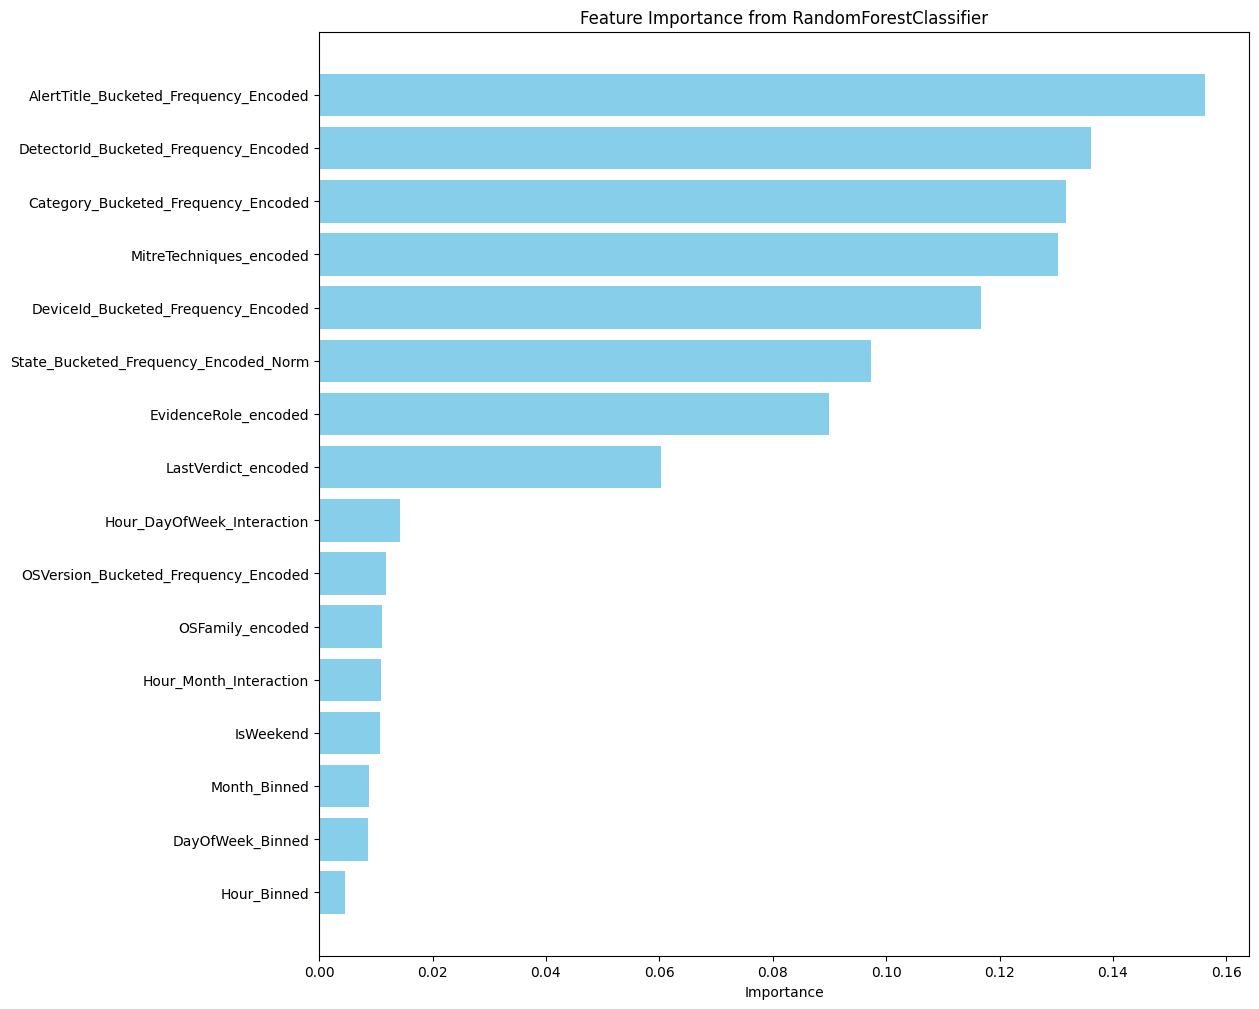

In [ ]:
#feature selection
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Load the resampled training data from pickle files
with open('/content/drive/MyDrive/X_train_resampled.pkl', 'rb') as f:
    X_train_resampled, y_train_resampled = pickle.load(f)

# Load the validation data (if needed for other tasks)
with open('/content/drive/MyDrive/validation_data.pkl', 'rb') as f:
    X_valid_split, y_valid_split = pickle.load(f)

# Check the first few rows of the data to verify loading (optional)
print(X_train_resampled.head())
print(y_train_resampled.head())

# Define and fit the RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_split=5, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Extract feature importances
importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature importances:")
print(feature_importances_df)

# Plot the feature importances
plt.figure(figsize=(12, 12))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from RandomForestClassifier')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()


In [ ]:

      #top 14 features selected

In [ ]:
 X_train_resampled.columns

Index(['IsWeekend', 'EvidenceRole_encoded', 'LastVerdict_encoded',
       'OSFamily_encoded', 'MitreTechniques_encoded',
       'Category_Bucketed_Frequency_Encoded',
       'AlertTitle_Bucketed_Frequency_Encoded',
       'DetectorId_Bucketed_Frequency_Encoded',
       'DeviceId_Bucketed_Frequency_Encoded',
       'OSVersion_Bucketed_Frequency_Encoded', 'Hour_Binned',
       'DayOfWeek_Binned', 'Month_Binned', 'Hour_DayOfWeek_Interaction',
       'Hour_Month_Interaction', 'State_Bucketed_Frequency_Encoded_Norm'],
      dtype='object')

 'Category_Bucketed_Frequency_Encoded',
       'EntityType_Bucketed_Frequency_Encoded',
       'AlertTitle_Bucketed_Frequency_Encoded',
       'DetectorId_Bucketed_Frequency_Encoded',
       'DeviceId_Bucketed_Frequency_Encoded',
       'OSVersion_Bucketed_Frequency_Encoded',
       'IpAddress_Bucketed_Frequency_Encoded',
       'OSFamily_Label_Encoded', 'LastVerdict_Label_Encoded', 'Month_Binned', 'Hour_DayOfWeek_Interaction',
       'Hour_Month_Interaction', 'CountryCode_Bucketed_Frequency_Encoded_Norm',
       'State_Bucketed_Frequency_Encoded_Norm',
       'City_Bucketed_Frequency_Encoded_Norm'

[
    'AlertTitle_Bucketed_Frequency_Encoded',
    'DetectorId_Bucketed_Frequency_Encoded',
    'Category_Bucketed_Frequency_Encoded',
    'MitreTechniques_encoded',
    'DeviceId_Bucketed_Frequency_Encoded',
    'State_Bucketed_Frequency_Encoded_Norm',
    'EvidenceRole_encoded','LastVerdict_encoded'
]


In [ ]:
#model selction and tuning
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the resampled training data
with open('/content/drive/MyDrive/X_train_resampled.pkl', 'rb') as f:
    X_resampled, y_resampled = pickle.load(f)

# Load the validation data
with open('/content/drive/MyDrive/validation_data.pkl', 'rb') as f:
    X_val, y_val = pickle.load(f)

# Define top 15 features based on feature importance
top_features= [
    'AlertTitle_Bucketed_Frequency_Encoded',
    'DetectorId_Bucketed_Frequency_Encoded',
    'Category_Bucketed_Frequency_Encoded',
    'MitreTechniques_encoded',
    'DeviceId_Bucketed_Frequency_Encoded',
    'State_Bucketed_Frequency_Encoded_Norm',
    'EvidenceRole_encoded','LastVerdict_encoded'
]

# Filter the datasets to keep only the top features
X_resampled_top = X_resampled[top_features]
X_val_top = X_val[top_features]

# Define categorical and numerical features based on top features
categorical_features = [col for col in top_features if X_resampled[col].dtype == 'category']
numerical_features = [col for col in top_features if X_resampled[col].dtype in ['int64', 'float64']]

# Prepare the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Apply preprocessing to the resampled training data
X_resampled_preprocessed = preprocessor.fit_transform(X_resampled_top)
with open('/content/drive/MyDrive/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
# Apply preprocessing to the validation data
X_val_preprocessed = preprocessor.transform(X_val_top)

# Initialize and train Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_resampled_preprocessed, y_resampled)

# Predict and evaluate Logistic Regression model
y_pred_log_reg = log_reg.predict(X_val_preprocessed)
print("Logistic Regression:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_log_reg))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_log_reg))

# Initialize and train Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_resampled_preprocessed, y_resampled)

# Predict and evaluate Decision Tree model
y_pred_decision_tree = decision_tree.predict(X_val_preprocessed)
print("Decision Tree:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_decision_tree))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_decision_tree))

# Initialize and train Random Forest model
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_resampled_preprocessed, y_resampled)

# Predict and evaluate Random Forest model
y_pred_random_forest = random_forest.predict(X_val_preprocessed)
print("Random Forest:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_random_forest))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_random_forest))

# Initialize and train XGBoost model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_resampled_preprocessed, y_resampled)

# Predict and evaluate XGBoost model
y_pred_xgb = xgb.predict(X_val_preprocessed)
print("XGBoost:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb))

# Initialize and train LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_resampled_preprocessed, y_resampled)

# Predict and evaluate LightGBM model
y_pred_lgb = lgb_model.predict(X_val_preprocessed)
print("LightGBM:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_lgb))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lgb))


Logistic Regression:
Confusion Matrix:
[[16065  1293  6054]
 [ 7070   760  6229]
 [ 5422   931  9464]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.69      0.62     23412
         1.0       0.25      0.05      0.09     14059
         2.0       0.44      0.60      0.50     15817

    accuracy                           0.49     53288
   macro avg       0.42      0.45      0.40     53288
weighted avg       0.44      0.49      0.44     53288

Decision Tree:
Confusion Matrix:
[[14740  4072  4600]
 [ 3980  5362  4717]
 [ 3169  2961  9687]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.63      0.65     23412
         1.0       0.43      0.38      0.41     14059
         2.0       0.51      0.61      0.56     15817

    accuracy                           0.56     53288
   macro avg       0.54      0.54      0.54     53288
weighted avg       0.56      0.56      0.56  

In [ ]:
import pickle

# Save the Logistic Regression model
with open('/content/drive/MyDrive/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)

# Save the Decision Tree model
with open('/content/drive/MyDrive/decision_tree_model.pkl', 'wb') as f:
    pickle.dump(decision_tree, f)

# Save the Random Forest model
with open('/content/drive/MyDrive/random_forest_model.pkl', 'wb') as f:
    pickle.dump(random_forest, f)

# Save the XGBoost model
with open('/content/drive/MyDrive/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)

# Save the LightGBM model
with open('/content/drive/MyDrive/lightgbm_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All models have been saved successfully.


In [ ]:
#final evaluation
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the preprocessor
with open('/content/drive/MyDrive/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

# Load the test data
test_df = pd.read_pickle('/content/drive/MyDrive/test_df_bd.pkl')  # Adjust the path as needed

# Define the features the model was trained on
model_features =  [
    'AlertTitle_Bucketed_Frequency_Encoded',
    'DetectorId_Bucketed_Frequency_Encoded',
    'Category_Bucketed_Frequency_Encoded',
    'MitreTechniques_encoded',
    'DeviceId_Bucketed_Frequency_Encoded',
     'State_Bucketed_Frequency_Encoded_Norm',
    'EvidenceRole_encoded','LastVerdict_encoded'
]

# Ensure test data only contains columns used in the model
X_test = test_df[model_features]

# Define the target column
y_test = test_df['IncidentGrade_encoded']

# Apply the preprocessor to the test data
X_test_preprocessed = preprocessor.transform(X_test)

# Load the best (XGBoost) model
with open('/content/drive/MyDrive/xgboost_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Predict on the preprocessed test data
y_test_pred = best_model.predict(X_test_preprocessed)

# Print confusion matrix and classification report
print("Confusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

# Calculate specific metrics manually
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')

print(f"Macro-F1 score on test data: {macro_f1:.4f}")
print(f"Precision on test data: {precision:.4f}")
print(f"Recall on test data: {recall:.4f}")


Confusion Matrix on Test Data:
[[49272 16075 15874]
 [12419 20058 16369]
 [11148 11616 37247]]

Classification Report on Test Data:
              precision    recall  f1-score   support

         0.0       0.68      0.61      0.64     81221
         1.0       0.42      0.41      0.42     48846
         2.0       0.54      0.62      0.58     60011

    accuracy                           0.56    190078
   macro avg       0.54      0.55      0.54    190078
weighted avg       0.57      0.56      0.56    190078

Macro-F1 score on test data: 0.5434
Precision on test data: 0.5442
Recall on test data: 0.5460


In [1]:
#hypertuning
import pandas as pd
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

# Load the resampled training data
with open('/content/drive/MyDrive/X_train_resampled.pkl', 'rb') as f:
    X_resampled, y_resampled = pickle.load(f)

# Load the validation data
with open('/content/drive/MyDrive/validation_data.pkl', 'rb') as f:
    X_val, y_val = pickle.load(f)

# Define top features
top_features = [
    'AlertTitle_Bucketed_Frequency_Encoded',
    'DetectorId_Bucketed_Frequency_Encoded',
    'Category_Bucketed_Frequency_Encoded',
    'MitreTechniques_encoded',
    'DeviceId_Bucketed_Frequency_Encoded',
    'State_Bucketed_Frequency_Encoded_Norm',
    'EvidenceRole_encoded',
    'LastVerdict_encoded'
]

# Filter datasets to keep only top features
X_resampled_top = X_resampled[top_features]
X_val_top = X_val[top_features]

# Define categorical and numerical features
categorical_features = [col for col in top_features if X_resampled[col].dtype == 'category']
numerical_features = [col for col in top_features if X_resampled[col].dtype in ['int64', 'float64']]

# Prepare the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define hyperparameter distributions
param_dist_xgb = {
    'clf__n_estimators': randint(100, 150),
    'clf__max_depth': randint(3, 6),
    'clf__learning_rate': uniform(0.01, 0.1)
}

param_dist_lgb = {
    'clf__num_leaves': randint(31, 61),
    'clf__max_depth': randint(-1, 8),
    'clf__learning_rate': uniform(0.01, 0.1),
    'clf__n_estimators': randint(100, 150)
}

param_dist_rf = {
    'clf__n_estimators': randint(100, 200),
    'clf__max_depth': randint(5, 15),
    'clf__min_samples_split': randint(2, 6),
    'clf__min_samples_leaf': randint(1, 5)
}

# Function to tune and evaluate a model
def tune_and_evaluate(pipeline, param_dist, X_train, y_train, X_val, y_val, model_name):
    random_search = RandomizedSearchCV(pipeline, param_dist, cv=3, scoring='accuracy', n_iter=10, n_jobs=-1, random_state=42, verbose=1)
    random_search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}:")
    print(random_search.best_params_)
    print(f"Best score for {model_name}:")
    print(random_search.best_score_)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_val)

    print(f"Best {model_name} Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

# Create and evaluate models
pipelines = {
    'XGBoost': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
    ]),
    'LightGBM': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', lgb.LGBMClassifier(random_state=42))
    ]),
    'RandomForest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', RandomForestClassifier(random_state=42))
    ])
}

# Tune and evaluate each model
for model_name, pipeline in pipelines.items():
    if model_name == 'XGBoost':
        tune_and_evaluate(pipeline, param_dist_xgb, X_resampled_top, y_resampled, X_val_top, y_val, model_name)
    elif model_name == 'LightGBM':
        tune_and_evaluate(pipeline, param_dist_lgb, X_resampled_top, y_resampled, X_val_top, y_val, model_name)
    elif model_name == 'RandomForest':
        tune_and_evaluate(pipeline, param_dist_rf, X_resampled_top, y_resampled, X_val_top, y_val, model_name)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:37:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost:
{'clf__learning_rate': 0.025601864044243652, 'clf__max_depth': 5, 'clf__n_estimators': 122}
Best score for XGBoost:
0.502030675479905
Best XGBoost Confusion Matrix:
[[16344  1106  5962]
 [ 6406  1778  5875]
 [ 4776   990 10051]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.70      0.64     23412
         1.0       0.46      0.13      0.20     14059
         2.0       0.46      0.64      0.53     15817

    accuracy                           0.53     53288
   macro avg       0.50      0.49      0.46     53288
weighted avg       0.52      0.53      0.49     53288

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info

In [1]:
import joblib
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Function to save models
def save_model(model, model_name):
    model_filename = f'/content/drive/MyDrive/best_{model_name.lower()}_model.pkl'
    joblib.dump(model, model_filename)
    print(f"Saved {model_name} model to {model_filename}")

# Save each model from the pipelines
for model_name, pipeline in pipelines.items():
    # Get the best model from the pipeline
    best_model = pipeline.named_steps['clf']  # Access the classifier in the pipeline
    save_model(best_model, model_name)


Mounted at /content/drive


NameError: name 'pipelines' is not defined

In [3]:
#StratifiedKFold cross validation
import pandas as pd
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# Load the stacking classifier model
with open('/content/drive/MyDrive/random_forest_model.pkl', 'rb') as f:
    stacking_clf = pickle.load(f)

# Load the dataset
test_df = pd.read_pickle('/content/drive/MyDrive/test_df_bd.pkl')  # Adjust the path as needed

# Define features and target
model_features = [
    'AlertTitle_Bucketed_Frequency_Encoded',
    'DetectorId_Bucketed_Frequency_Encoded',
    'Category_Bucketed_Frequency_Encoded',
    'MitreTechniques_encoded',
    'DeviceId_Bucketed_Frequency_Encoded',
    'State_Bucketed_Frequency_Encoded_Norm',
    'EvidenceRole_encoded',
    'LastVerdict_encoded'
]
X = test_df[model_features]
y = test_df['IncidentGrade_encoded']

# Define categorical and numerical features
categorical_features = [col for col in model_features if X[col].dtype == 'category']
numerical_features = [col for col in model_features if X[col].dtype in ['int64', 'float64']]

# Prepare the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Create the pipeline with the stacking classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', stacking_clf)])

# Define the cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_macro')  # Use 'f1_macro' for macro-average F1 score

print(f"Cross-Validation F1 Macro Score: {scores.mean():.4f} ± {scores.std():.4f}")

# Optionally, evaluate other metrics
scoring = {
    'f1': make_scorer(f1_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
}
cross_val_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)

print(f"Cross-Validation F1 Macro Score: {cross_val_results['test_f1'].mean():.4f} ± {cross_val_results['test_f1'].std():.4f}")
print(f"Cross-Validation Precision: {cross_val_results['test_precision'].mean():.4f} ± {cross_val_results['test_precision'].std():.4f}")
print(f"Cross-Validation Recall: {cross_val_results['test_recall'].mean():.4f} ± {cross_val_results['test_recall'].std():.4f}")


Cross-Validation F1 Macro Score: 0.5170 ± 0.0025
Cross-Validation F1 Macro Score: 0.5170 ± 0.0025
Cross-Validation Precision: 0.5830 ± 0.0093
Cross-Validation Recall: 0.5261 ± 0.0021


In [4]:
#StratifiedKFold cross validation
import pandas as pd
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# Load the  classifier model
with open('/content/drive/MyDrive/lightgbm_model.pkl', 'rb') as f:
    stacking_clf = pickle.load(f)

# Load the dataset
test_df = pd.read_pickle('/content/drive/MyDrive/test_df_bd.pkl')  # Adjust the path as needed

# Define features and target
model_features = [
    'AlertTitle_Bucketed_Frequency_Encoded',
    'DetectorId_Bucketed_Frequency_Encoded',
    'Category_Bucketed_Frequency_Encoded',
    'MitreTechniques_encoded',
    'DeviceId_Bucketed_Frequency_Encoded',
    'State_Bucketed_Frequency_Encoded_Norm',
    'EvidenceRole_encoded',
    'LastVerdict_encoded'
]
X = test_df[model_features]
y = test_df['IncidentGrade_encoded']

# Define categorical and numerical features
categorical_features = [col for col in model_features if X[col].dtype == 'category']
numerical_features = [col for col in model_features if X[col].dtype in ['int64', 'float64']]

# Prepare the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Create the pipeline with the stacking classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', stacking_clf)])

# Define the cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_macro')  # Use 'f1_macro' for macro-average F1 score

print(f"Cross-Validation F1 Macro Score: {scores.mean():.4f} ± {scores.std():.4f}")

# Optionally, evaluate other metrics
scoring = {
    'f1': make_scorer(f1_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
}
cross_val_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)

print(f"Cross-Validation F1 Macro Score: {cross_val_results['test_f1'].mean():.4f} ± {cross_val_results['test_f1'].std():.4f}")
print(f"Cross-Validation Precision: {cross_val_results['test_precision'].mean():.4f} ± {cross_val_results['test_precision'].std():.4f}")
print(f"Cross-Validation Recall: {cross_val_results['test_recall'].mean():.4f} ± {cross_val_results['test_recall'].std():.4f}")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 152062, number of used features: 8
[LightGBM] [Info] Start training from score -0.850270
[LightGBM] [Info] Start training from score -1.358754
[LightGBM] [Info] Start training from score -1.152900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 152062, number of used features: 8
[LightGBM] [Info] Start training from score -0.850255
[LightGBM] [Info] Start training from score -1.358780
[LightGBM] [Info] Start tr

In [ ]:
#stacking classifier
import pickle
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load base models
with open('/content/drive/MyDrive/xgboost_model.pkl', 'rb') as f:
    xgboost = pickle.load(f)
with open('/content/drive/MyDrive/lightgbm_model.pkl', 'rb') as f:
    lightgbm = pickle.load(f)
with open('/content/drive/MyDrive/random_forest_model.pkl', 'rb') as f:
    randomforest = pickle.load(f)

# Define the meta-model
meta_model = LogisticRegression()

# Define the stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', xgboost),
        ('rf', lightgbm),
        ('lgb', randomforest)
    ],
    final_estimator=meta_model
)

# Define top features
top_features = [
    'AlertTitle_Bucketed_Frequency_Encoded',
    'DetectorId_Bucketed_Frequency_Encoded',
    'Category_Bucketed_Frequency_Encoded',
    'MitreTechniques_encoded',
    'DeviceId_Bucketed_Frequency_Encoded',
    'State_Bucketed_Frequency_Encoded_Norm',
    'EvidenceRole_encoded',
    'LastVerdict_encoded'
]

# Load your dataset
with open('/content/drive/MyDrive/X_train_resampled.pkl', 'rb') as f:
    X_resampled, y_resampled = pickle.load(f)
with open('/content/drive/MyDrive/validation_data.pkl', 'rb') as f:
    X_val, y_val = pickle.load(f)

# Filter the datasets to keep only the top features
X_resampled_top = X_resampled[top_features]
X_val_top = X_val[top_features]

# Define categorical and numerical features based on top features
categorical_features = [col for col in top_features if X_resampled_top[col].dtype == 'category']
numerical_features = [col for col in top_features if X_resampled_top[col].dtype in ['int64', 'float64']]

# Prepare the transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Apply preprocessing to the datasets
X_resampled_preprocessed = preprocessor.fit_transform(X_resampled_top)
X_val_preprocessed = preprocessor.transform(X_val_top)

# Train the stacking classifier
stacking_clf.fit(X_resampled_preprocessed, y_resampled)

# Make predictions and evaluate
y_pred = stacking_clf.predict(X_val_preprocessed)
print("Stacking Classifier Accuracy:", accuracy_score(y_val, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 280941, number of used features: 8
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 224752, number of used features: 8
[LightGBM] [Info] Start training from score -1.098617
[LightGBM] [Info] Start training from score -1.098617
[LightGBM] [Info] Start 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Make predictions on the validation set
y_pred = stacking_clf.predict(X_val_preprocessed)

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

# Alternatively, use classification_report for a detailed report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)


Precision: 0.5677
Recall: 0.5567
F1 Score: 0.5606
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.61      0.65     23412
         1.0       0.41      0.45      0.43     14059
         2.0       0.53      0.58      0.55     15817

    accuracy                           0.56     53288
   macro avg       0.54      0.54      0.54     53288
weighted avg       0.57      0.56      0.56     53288



In [ ]:
import pickle

# Save the StackingClassifier model
with open('/content/drive/MyDrive/stacking_classifier_model.pkl', 'wb') as f:
    pickle.dump(stacking_clf, f)

print("Stacking Classifier model saved successfully.")


Stacking Classifier model saved successfully.


In [ ]:
import pickle

# Load the StackingClassifier model
with open('/content/drive/MyDrive/stacking_classifier_model.pkl', 'rb') as f:
    loaded_stacking_clf = pickle.load(f)

print("Stacking Classifier model loaded successfully.")


Stacking Classifier model loaded successfully.


In [ ]:
#final
#final evaluation with stacking classifier
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the preprocessor
with open('/content/drive/MyDrive/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

# Load the test data
test_df = pd.read_pickle('/content/drive/MyDrive/test_df_bd.pkl')  # Adjust the path as needed

# Define the features the model was trained on
model_features =  [
    'AlertTitle_Bucketed_Frequency_Encoded',
    'DetectorId_Bucketed_Frequency_Encoded',
    'Category_Bucketed_Frequency_Encoded',
    'MitreTechniques_encoded',
    'DeviceId_Bucketed_Frequency_Encoded',
     'State_Bucketed_Frequency_Encoded_Norm',
    'EvidenceRole_encoded','LastVerdict_encoded'
]

# Ensure test data only contains columns used in the model
X_test = test_df[model_features]

# Define the target column
y_test = test_df['IncidentGrade_encoded']

# Apply the preprocessor to the test data
X_test_preprocessed = preprocessor.transform(X_test)

# Load the best (XGBoost) model
with open('/content/drive/MyDrive/stacking_classifier_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Predict on the preprocessed test data
y_test_pred = best_model.predict(X_test_preprocessed)

# Print confusion matrix and classification report
print("Confusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

# Calculate specific metrics manually
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')

print(f"Macro-F1 score on test data: {macro_f1:.4f}")
print(f"Precision on test data: {precision:.4f}")
print(f"Recall on test data: {recall:.4f}")


Confusion Matrix on Test Data:
[[46387 20132 14702]
 [10211 23445 15190]
 [ 8955 14796 36260]]

Classification Report on Test Data:
              precision    recall  f1-score   support

         0.0       0.71      0.57      0.63     81221
         1.0       0.40      0.48      0.44     48846
         2.0       0.55      0.60      0.57     60011

    accuracy                           0.56    190078
   macro avg       0.55      0.55      0.55    190078
weighted avg       0.58      0.56      0.56    190078

Macro-F1 score on test data: 0.5481
Precision on test data: 0.5525
Recall on test data: 0.5518
